In [ ]:
import os #interaccion entre carpetas
import torch # pytorch maneja tensores CPU y GPU
from torch.utils.data import DataLoader #crea iteradores 
from torchvision import datasets, transforms #permite crear transformaciones
import shutil #copiar mover archivos 
import random #genera numeros aleatorios
import torchvision.transforms as T #permite manejarlo mas facil
from PIL import Image  #abrir procesar manipular imagenes 
from torch.utils.data import Dataset #permite crear dataset propio
import torch.nn as nn #Contiene capas y modelos clasicos
import torch.nn.functional as F #funciones de activacion
import torch.optim as optim #optimizadores 
from torchvision import transforms, models #permite usar modelos pre entrenados


os.getcwd()
os.listdir()
train_dir = r"C:\Users\Usuario\Escritorio\Auto2\imagenes\train"
val_dir = r"C:\Users\Usuario\Escritorio\Auto2\imagenes\validation"
os.chdir(r"C:\Users\Usuario\Desktop\Auto2\imagenes")
os.listdir()
train_dir = "train"  #Dorectorio
val_dir = "validation" #Directorio

In [119]:
#Carpeta origen
src_joven = "joven"
src_viejo = "viejo"

#Destino
train_joven = "train/joven"
train_viejo = "train/viejo"
val_joven = "validation/joven"
val_viejo = "validation/viejo"

# Crear carpetas destino si no existen
os.makedirs(train_joven, exist_ok=True)
os.makedirs(train_viejo, exist_ok=True)
os.makedirs(val_joven, exist_ok=True)
os.makedirs(val_viejo, exist_ok=True)

# Divide las imagenes
def split_and_move(src, train_dst, val_dst, split=0.8): #Carpeta origen, Carpeta final, Carpeta de validacion, porcentaje de entrenamiento

    # Obtener solo archivos de imagen
    files = [
        f for f in os.listdir(src)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]

    # Mezclar al azar
    random.shuffle(files)

    # Calcular índice de separación
    split_idx = int(len(files) * split)

    # Separar en train y validation
    train_files = files[:split_idx]
    val_files = files[split_idx:]

    print(f"{src}: {len(train_files)} para train, {len(val_files)} para validation")

    # Mover imágenes a las carpetas de train
    for f in train_files:
        shutil.move(os.path.join(src, f), os.path.join(train_dst, f))

    # Mover imágenes a las carpetas de val
    for f in val_files:
        shutil.move(os.path.join(src, f), os.path.join(val_dst, f))


In [120]:
print("train/joven:", len(os.listdir("train/joven")))
print("train/viejo:", len(os.listdir("train/viejo")))
print("validation/joven:", len(os.listdir("validation/joven")))
print("validation/viejo:", len(os.listdir("validation/viejo")))


train/joven: 59
train/viejo: 34
validation/joven: 15
validation/viejo: 9


In [121]:
# Transformacion (aumentar Training)
train_transform = T.Compose([
    
    # 1. Cambios aleatorios
    T.RandomHorizontalFlip(p=0.5),       # voltear imagen
    T.RandomRotation(degrees=10),        # rotación
    T.RandomResizedCrop(
        size=(300, 300),                 # mismo tamaño
        scale=(0.9, 1.1),                # zoom in/out 
        ratio=(0.9, 1.1)                 # estiramiento 
    ),

    # 3. Convertir
    T.ToTensor(),

    # 4. Normalización para CNN
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

#Transformaciones para Val 
test_transform = T.Compose([
    T.Resize((300, 300)), 
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])


In [122]:
# Dataset personalizado
class AgeDataset(Dataset): # crea un dataset, Lee imagenes de las carpetas, asigna etiquetas, aplica transformaciones
    def __init__(self, root_dir, transform=None): #contruye, va a las carpetas que contiene joven y viejo, aplica transformaciones
        self.root_dir = root_dir
        self.transform = transform
        # Las clases
        self.classes = ["joven", "viejo"]
        # Lista donde se guardan imagenes y etiquetas
        self.image_paths = []
        self.labels = []
        # Recorrer cada clase
        for idx, classname in enumerate(self.classes):
            # Carpeta de la clase (data/train/joven/)
            class_folder = os.path.join(root_dir, classname)

            # Validar que existe
            if not os.path.isdir(class_folder):
                raise RuntimeError(f"No existe la carpeta: {class_folder}")

            # Recorre las imágenes
            for image_name in os.listdir(class_folder):
                full_path = os.path.join(class_folder, image_name)

                # Aceptar solo archivos
                if os.path.isfile(full_path):
                    self.image_paths.append(full_path)
                    self.labels.append(idx)

        # Confirmación
        print(f"[OK] Dataset cargado desde: {root_dir}")
        print(f"     Total imágenes: {len(self.image_paths)}")
        print(f"     jóven: {self.labels.count(0)} | viejo: {self.labels.count(1)}")

    def __len__(self):
        return len(self.image_paths) #Retorna elementos del dataset

    def __getitem__(self, idx): #Carga imagenes y etiquetas

        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Abrir imagen con PIL
        image = Image.open(img_path).convert("RGB")

        # Aplicar transformaciones
        if self.transform:
            image = self.transform(image)

        return image, label


In [123]:
import os
os.chdir(r"C:\Users\Usuario\Desktop\Auto2")
os.getcwd()

'C:\\Users\\Usuario\\Desktop\\Auto2'

In [124]:
#Dataloader despues de transoformacuiones
train_dir = "data/train"
val_dir   = "data/val"
test_dir  = "data/test"

train_dataset = AgeDataset(train_dir, transform=train_transform)  # aplica augmentación
val_dataset   = AgeDataset(val_dir,   transform=test_transform)   # solo resize + normalización
test_dataset  = AgeDataset(test_dir,  transform=test_transform)


[OK] Dataset cargado desde: data/train
     Total imágenes: 118
     jóven: 75 | viejo: 43
[OK] Dataset cargado desde: data/val
     Total imágenes: 81
     jóven: 49 | viejo: 32
[OK] Dataset cargado desde: data/test
     Total imágenes: 74
     jóven: 43 | viejo: 31


In [125]:
from torch.utils.data import DataLoader

# cuántas imágenes entran por paso
batch_size = 32

# DataLoader para entrenamiento
# shuffle=True mezcla las imágenes en cada época
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# DataLoader para validación y prueba
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

#cuántos batches se crearon en cada dataset
print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))
print("Test batches:", len(test_loader))


Train batches: 4
Val batches: 3
Test batches: 3


In [ ]:
#   CNN 
# - 2 bloques convolucionales
# - MaxPooling para reducción de dimensionalidad
# - Capa totalmente conectada final para clasificar 2 clases

class SimpleCNN(nn.Module): #Rastrear parametros 
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Primer bloque convolucional Deteccion de bordes y texturas
        self.conv1 = nn.Conv2d(
            in_channels=3,      # imágenes RGB (3 canales)
            out_channels=32,    # 32 de filtros
            kernel_size=3,      # filtro 3x3
            padding=1           #Mantiene el tamaño de entrada
        )

        # Segundo bloque convolucional Aprende formas, rasgos faciales
        self.conv2 = nn.Conv2d(
            in_channels=32, #Tamaño de filtro de entrada 
            out_channels=64, #Aprende 64 filtros nuevos
            kernel_size=3,
            padding=1
        )
        # MaxPooling (declaro las capas)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # después de dos maxpools tu imagen pasa de 300x300 a 75x75
        self.fc1 = nn.Linear(64 * 75 * 75, 128) #64 filtros, imagen, 128 neuronas internas
        self.fc2 = nn.Linear(128, 2)  # 2 clases joven y viejo

    def forward(self, x):
        # Bloque Conv 1
        x = F.relu(self.conv1(x)) #aplica funcion de activacion
        x = F.max_pool2d(x, 2)  # reduce tamaño a la mitad

        # Bloque Conv 2
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)  # reduce tamaño a la mitad

        # Aplanar antes de FC
        x = x.view(x.size(0), -1)

        # FC y ReLU
        x = F.relu(self.fc1(x))

        # Capa final
        x = self.fc2(x)
        return x


# Creacion de la red
model = SimpleCNN()

# Elegir dispositivo 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("Modelo cargado en:", device)


Modelo cargado en: cpu


In [129]:
# Entrenamiento
# Función de pérdida para clasificación multiclase
criterion = nn.CrossEntropyLoss()

# Optimizador Adam por tener pocos datos
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Número de épocas
num_epochs = 15


In [130]:
# LOOP DE ENTRENAMIENTO

for epoch in range(num_epochs):
    model.train()  # modo entrenamiento acumula epocas 
    running_loss = 0
    correct = 0
    total = 0

    # Entrenar en batches
    for images, labels in train_loader: #iteracion sobre batches
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images) #pasa images por la red y obtiene las salidas
        loss = criterion(outputs, labels) #Calcula la perdida para el batch

        # Gradientes
        optimizer.zero_grad() #Limpia gradientes utilizados, evita acumulacion
        loss.backward() #perdida respecto a parametros del modelo
        optimizer.step() #Actualiza los parametros del modelo con Adam

        # Métricas
        running_loss += loss.item() #suma la perdida por batch
        _, predicted = torch.max(outputs, 1) #Indice con clase de mayor puntuacion
        total += labels.size(0)
        correct += (predicted == labels).sum().item() #Suma predicciones reales

    train_acc = 100 * correct / total # portcentajes

    # Validación
    model.eval() #Desactiva Dropout 
    val_correct = 0 #inicializadores 
    val_total = 0
    val_loss_total = 0

    with torch.no_grad(): #Desactiva el calculo de gradientes 
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss_total += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total

    print(f"Época [{epoch+1}/{num_epochs}]  "
          f"Train Loss: {running_loss:.3f}  Train Acc: {train_acc:.2f}%  "
          f"Val Loss: {val_loss_total:.3f}  Val Acc: {val_acc:.2f}%")


Época [1/15]  Train Loss: 43.132  Train Acc: 50.00%  Val Loss: 4.781  Val Acc: 39.51%
Época [2/15]  Train Loss: 5.874  Train Acc: 50.00%  Val Loss: 3.032  Val Acc: 60.49%
Época [3/15]  Train Loss: 3.386  Train Acc: 58.47%  Val Loss: 2.458  Val Acc: 44.44%
Época [4/15]  Train Loss: 2.650  Train Acc: 60.17%  Val Loss: 2.602  Val Acc: 61.73%
Época [5/15]  Train Loss: 3.114  Train Acc: 64.41%  Val Loss: 2.647  Val Acc: 61.73%
Época [6/15]  Train Loss: 2.518  Train Acc: 65.25%  Val Loss: 1.768  Val Acc: 74.07%
Época [7/15]  Train Loss: 2.287  Train Acc: 72.03%  Val Loss: 1.764  Val Acc: 69.14%
Época [8/15]  Train Loss: 2.235  Train Acc: 75.42%  Val Loss: 1.801  Val Acc: 72.84%
Época [9/15]  Train Loss: 2.108  Train Acc: 73.73%  Val Loss: 1.930  Val Acc: 72.84%
Época [10/15]  Train Loss: 2.198  Train Acc: 72.88%  Val Loss: 1.873  Val Acc: 74.07%
Época [11/15]  Train Loss: 2.182  Train Acc: 73.73%  Val Loss: 1.706  Val Acc: 74.07%
Época [12/15]  Train Loss: 2.014  Train Acc: 76.27%  Val Loss:

In [ ]:
# Metricas de entrenamiento
# loss (entrenamiento y validación):
# La pérdida de entrenamiento, muestra aprendizaje real.
# La pérdida de validación, buen desempeño sin sobreajuste.

# accuracy (entrenamiento y validación):
# Porcentaje de predicciones correctas.
# indica que el modelo generaliza bien.

In [131]:
num_classes = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [132]:
print(num_classes)
print(device)
print(len(train_loader.dataset), len(val_loader.dataset))


2
cpu
118 81


In [133]:
# Modelo RESNET18 

# modelo preentrenado ResNet18
from torchvision import models

# Cargar ResNet18 
# pretrained=True carga pesos ya entrenados con millones de imágenes
resnet = models.resnet18(pretrained=True)

# Congelar las capas convolucionales
# Esto evita que se modifiquen los pesos base y acelera el entrenamiento
for param in resnet.parameters():
    param.requires_grad = False

# Reemplazar la última capa para ajustar a nuestras clases
# features llegan al clasificador final
num_features = resnet.fc.in_features

# Se reemplaza 
resnet.fc = nn.Linear(num_features, num_classes)

# envia el Modelo a donde lo estamos utilizando
resnet = resnet.to(device)

# Define funcion de perdida y optimizador
criterion = nn.CrossEntropyLoss()

# Solo se entrenan los parámetros de la última capa
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)

# Entrenamiento
num_epochs = 10
train_losses_resnet = []
val_losses_resnet = []
train_acc_resnet = []
val_acc_resnet = []


for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0
    correct_preds = 0
    total_preds = 0

    #  Entrenamiento
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = (correct_preds / total_preds) * 100

    train_losses_resnet.append(epoch_train_loss)
    train_acc_resnet.append(epoch_train_acc)
    
    #  Validación
    resnet.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = resnet(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_acc = (val_correct / val_total) * 100

    val_losses_resnet.append(epoch_val_loss)
    val_acc_resnet.append(epoch_val_acc)

    #Resultados
    print(f"Época [{epoch+1}/{num_epochs}]  "
          f"Train Loss: {epoch_train_loss:.4f}  Train Acc: {epoch_train_acc:.2f}%  "
          f"Val Loss: {epoch_val_loss:.4f}  Val Acc: {epoch_val_acc:.2f}%")

print("\n================== ENTRENAMIENTO RESNET TERMINADO ==================\n")


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Época [1/10]  Train Loss: 0.6669  Train Acc: 61.02%  Val Loss: 0.6832  Val Acc: 60.49%
Época [2/10]  Train Loss: 0.6102  Train Acc: 66.10%  Val Loss: 0.6815  Val Acc: 60.49%
Época [3/10]  Train Loss: 0.6402  Train Acc: 63.56%  Val Loss: 0.6401  Val Acc: 61.73%
Época [4/10]  Train Loss: 0.5841  Train Acc: 69.49%  Val Loss: 0.6267  Val Acc: 62.96%
Época [5/10]  Train Loss: 0.5736  Train Acc: 74.58%  Val Loss: 0.6007  Val Acc: 62.96%
Época [6/10]  Train Loss: 0.5673  Train Acc: 70.34%  Val Loss: 0.6081  Val Acc: 62.96%
Época [7/10]  Train Loss: 0.5489  Train Acc: 71.19%  Val Loss: 0.5532  Val Acc: 66.67%
Época [8/10]  Train Loss: 0.5265  Train Acc: 76.27%  Val Loss: 0.5612  Val Acc: 66.67%
Época [9/10]  Train Loss: 0.5344  Train Acc: 72.88%  Val Loss: 0.5523  Val Acc: 66.67%
Época [10/10]  Train Loss: 0.5091  Train Acc: 77.97%  Val Loss: 0.5100  Val Acc: 67.90%

================== ENTRENAMIENTO RESNET TERMINADO ==================



In [ ]:
#Metricas cpn RESNET18

#Los resultados por época muestran cómo evoluciona el aprendizaje del modelo:
# el modelo está aprendiendo los patrones de las imágenes.
# e modelo mejora su capacidad de clasificar correctamente las imágenes que ya ha visto.
# el modelo no solo memoriza, sino que también mejora en datos nuevos.

In [134]:
#Embeddings para random Forest
import torch
from torchvision import models

# Cargar MobileNetV2 preentrenado en ImageNet
model_feat = models.mobilenet_v2(weights="IMAGENET1K_V1")

# Reemplazar la capa final por una identidad para obtener los embeddings
# MobileNetV2 produce un vector de 1280 dimensiones
model_feat.classifier = torch.nn.Identity()

model_feat = model_feat.to(device)
model_feat.eval()

print("Extractor de embeddings listo (MobileNetV2)")


Extractor de embeddings listo (MobileNetV2)


In [135]:
import numpy as np

def extract_embeddings(dataloader, model): #extrae los ebeddings para cada imagen dataloader
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)

            # Obtener características de MobileNetV2
            feat = model(x)               # salida: [batch_size, 1280]
            feat = feat.cpu().numpy()     # mover a numpy

            embeddings.append(feat)
            labels.append(y.numpy())

    return np.vstack(embeddings), np.hstack(labels)


In [136]:
#Obtener Embeddings
X_train_emb, y_train = extract_embeddings(train_loader, model_feat)
X_val_emb,   y_val   = extract_embeddings(val_loader, model_feat)
X_test_emb,  y_test  = extract_embeddings(test_loader, model_feat)

print("Shapes:")
print(X_train_emb.shape, y_train.shape)
print(X_val_emb.shape, y_val.shape)
print(X_test_emb.shape, y_test.shape)


Shapes:
(118, 1280) (118,)
(81, 1280) (81,)
(74, 1280) (74,)


In [138]:
#Escalar Features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Ajustar Solo train
X_train_scaled = scaler.fit_transform(X_train_emb)

# Transformar val/test
X_val_scaled   = scaler.transform(X_val_emb)
X_test_scaled  = scaler.transform(X_test_emb)

print("Escalado listo.")


Escalado listo.


In [139]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)

rf.fit(X_train_scaled, y_train)

print("Random Forest entrenado.")


Random Forest entrenado.


In [141]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = rf.predict(X_test_scaled)

print("Accuracy en Test:", accuracy_score(y_test, y_pred))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))


Accuracy en Test: 0.8783783783783784

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        43
           1       0.89      0.81      0.85        31

    accuracy                           0.88        74
   macro avg       0.88      0.87      0.87        74
weighted avg       0.88      0.88      0.88        74



In [ ]:
#metricas del Random Forest
#El modelo Random Forest logra un buen desempeño general usando únicamente
#los embeddings extraídos de las imágenes

#CLASE 0 (jóven)
# El modelo reconoce a TODOS los jóvenes correctamente (no deja escapar ninguno).
# Buen equilibrio entre precisión y recall.
#- El modelo es muy bueno clasificando a los jóvenes 


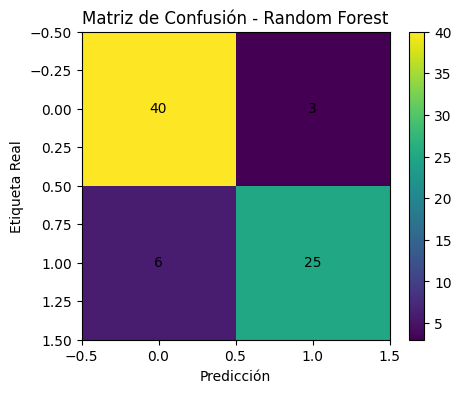

In [142]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# MATRIZ DE CONFUSIÓN PARA COMPARAR MODELOS
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title("Matriz de Confusión - Random Forest")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.colorbar()

# Mostrar valores en la matriz
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.show()


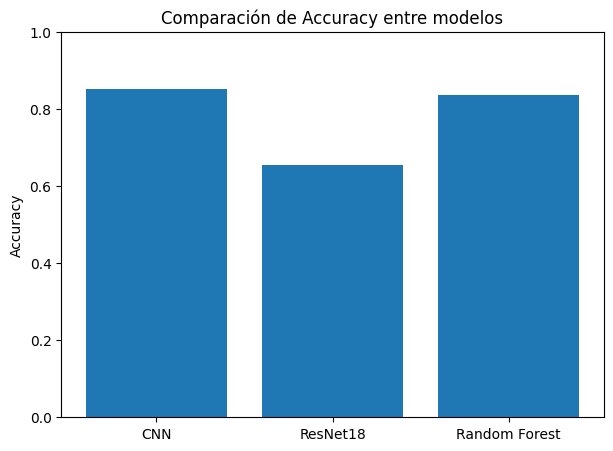

In [ ]:
import matplotlib.pyplot as plt

# Metricas
acc_cnn = 0.8519
acc_resnet = 0.6543
acc_rf = 0.8378

modelos = ["CNN", "ResNet18", "Random Forest"]
accuracies = [acc_cnn, acc_resnet, acc_rf]

plt.figure(figsize=(7,5))
plt.bar(modelos, accuracies)
plt.ylim(0,1)
plt.title("Comparación de Accuracy entre modelos")
plt.ylabel("Accuracy")
plt.show()


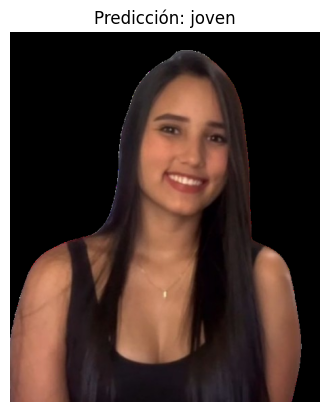

Probabilidades: [[0.61130595 0.38869402]]
Predicción final: joven


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Configutacion
ruta_imagen = r"C:\Users\Usuario\Desktop\Auto2\imagenes\Prueba.png"   # ruta

model.eval()

# TRANSFORMACIONES
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor()
])

# Cargar imagen
img = Image.open(ruta_imagen).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)

# Prediccion
with torch.no_grad():
    logits = model(img_tensor)      # salida del modelo
    probs = F.softmax(logits, dim=1)
    pred = torch.argmax(probs, dim=1).item()

clases = ["joven", "viejo"]
resultado = clases[pred]

# Resultado
plt.imshow(img)
plt.title(f"Predicción: {resultado}")
plt.axis("off")
plt.show()

print("Probabilidades:", probs.cpu().numpy())
print("Predicción final:", resultado)
